In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['font.sans-serif'] = ['SimHei']

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# 读取数据
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# 查看数据基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# 缺失值处理
data.isnull().sum()
# 本文做用户价值分析， CustomerID的缺失会对结果产生影响，所以缺失值不能填补上的话需删除

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# 查看缺失值的数量与比例
(pd.DataFrame({
        "NaN_num": round(data.isnull().sum(),2),
        "NaN_percent":(data.isnull().sum()/data.shape[0]).apply(lambda x:str(round(x*100,2))+'%'),
            })
  .sort_values('NaN_num', ascending=False))

,NaN_num,NaN_percent
CustomerID,135080,24.93%
Description,1454,0.27%
InvoiceNo,0,0.0%
StockCode,0,0.0%
Quantity,0,0.0%
InvoiceDate,0,0.0%
UnitPrice,0,0.0%
Country,0,0.0%


In [7]:
# 将Description和CustomerID存在的缺失值做删除处理
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
# 删除重复值
# 共删除5225条重复值
dataUni = data.drop_duplicates()
data.shape[0]-dataUni.shape[0]

5225

In [9]:
# 异常值处理
# 描述性统计
dataUni[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [10]:
dataUni.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
# Quantity是购买的产品数量，存在负数表示退货订单，这里分析不考虑退货订单信息，直接删除，UnitPrice是单价，不可能存在负值，直接删除异常值
sale = dataUni.loc[(dataUni['Quantity']>0) & (dataUni['UnitPrice']>0)]

In [12]:
sale.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
# 辅助列
sale['CustomerID'] = sale['CustomerID'].astype(int)
# 添加总价列,表示购买某一种商品的总额
sale['TotalSum'] = sale['UnitPrice']*sale['Quantity']   
# 对时间属性做转换，保留年月日
sale['InvoiceDate'] = pd.to_datetime(sale.InvoiceDate)
sale['Date'] = sale['InvoiceDate'].dt.date
# 添加年,月,日,日期列
sale['Year'] = sale['InvoiceDate'].dt.year
sale['Month'] = sale['InvoiceDate'].dt.month
sale['Day'] = sale['InvoiceDate'].dt.day
sale.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,Date,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1


RFM模型

使用RFM模型对用户进行分类，根据用户分类，识别出有价值的用户，对不同价值的用户使用不同的运营策略，把公司有限的资源发挥到最大的效果。

这3个指标针对的业务不同，定义也不同，要根据业务来灵活定义，各指标特征如下：

对于最近1次消费时间间隔R，上一次消费离的越近，也就是R值越小，用户价值越高。

对于消费频率F，购买的频率越高，也就是F的值越大，用户价值越高。

对于消费金额M，消费金额越高，也就是M的值越大，用户价值越高

In [14]:
# 建立用户数据表，每一行代表一个用户的信息
# 取最大日期加1天为分析时间，以分析时间减去客户最后一次消费时间，时间差算出R频率
Nowdate = sale.Date.max()+dt.timedelta(days=1)   # 分析时间
CusDate = sale.groupby(['CustomerID']).agg({'Date':lambda x:(Nowdate-x.max()).days,'TotalSum':'sum'}).reset_index()  # dt.days取出days
CusDate.rename(columns={'Date':'Recency','TotalSum':'MonetaryValue'},inplace=True)   # 重命名
CusDate.head()

,CustomerID,Recency,MonetaryValue
0,12346,326,77183.60
1,12347,3,4310.00
2,12348,76,1797.24
3,12349,19,1757.55
4,12350,311,334.40


In [17]:
# 分箱并评分,每层数量接近
Rquartiles = Rquartiles = pd.qcut(CusDate['Recency'], q=5, duplicates='drop',labels=[5,4,3,2,1]) 
CusDate = CusDate.assign(Recency_Q = Rquartiles.values )
CusDate.head()

,CustomerID,Recency,MonetaryValue,Recency_Q
0,12346,326,77183.60,1
1,12347,3,4310.00,5
2,12348,76,1797.24,2
3,12349,19,1757.55,4
4,12350,311,334.40,1


In [15]:
# 切片情况呈现,每隔一个月作为一个区间
bins_R = np.arange(14)
pd.cut(CusDate['R_month'],bins_R).value_counts()

(0, 1]      1628
(1, 2]       748
(2, 3]       513
(3, 4]       229
(5, 6]       180
(4, 5]       179
(8, 9]       166
(6, 7]       155
(7, 8]       153
(9, 10]      119
(10, 11]     116
(12, 13]      93
(11, 12]      59
Name: R_month, dtype: int64

In [18]:
# 定义一个分箱后的统计函数
def rfm_bins_statistics(feature, scores, name):
    feature_statistic= pd.concat([feature,CusDate['MonetaryValue'],scores],axis=1)
    feature_statistic.columns = [name, 'Monetary', 'label']
    feature_bins = feature_statistic.groupby('label')[name].max().tolist()
    feature_bins_min = [-1]+feature_bins # 辅助列
    feature_label_statistic = feature_statistic.groupby('label').agg({
            '{}'.format(name):['count',('per1', lambda x: "%.1f"%((x.count() / feature_statistic[name].count()*100)) + '%')],
            'Monetary':['sum',('per2', lambda x: "%.1f"%((x.sum() / feature_statistic.Monetary.sum()*100)) + '%')],
        }).assign(range_ = [str(i+1) + '-' + str(j) for i,j in zip(feature_bins_min, feature_bins )] )
    return feature_statistic , feature_label_statistic, feature_bins

In [19]:
Recency_statistic,Recency_label_statistic, Recency_bins = rfm_bins_statistics(CusDate['Recency'], CusDate['Recency_Q'], 'Rec')
Recency_label_statistic

Rec            Monetary          range_
      count   per1          sum   per2         
label                                          
5       868  20.0%  4653608.380  52.4%     0-13
4       880  20.3%  1764915.281  19.9%    14-33
3       863  19.9%  1129672.500  12.7%    34-72
2       866  20.0%   783858.332   8.8%   73-180
1       861  19.8%   555154.401   6.2%  181-374

In [20]:
# 各天数消费金额之和
Monetary_sum = pd.concat([CusDate['Recency'].value_counts().sort_index(),CusDate.groupby('Recency').MonetaryValue.sum()], axis=1)
# 层级消费金额按照天数范围从小到大的累计之和
Monetary_range = Recency_label_statistic['Monetary', 'sum'].cumsum().tolist()

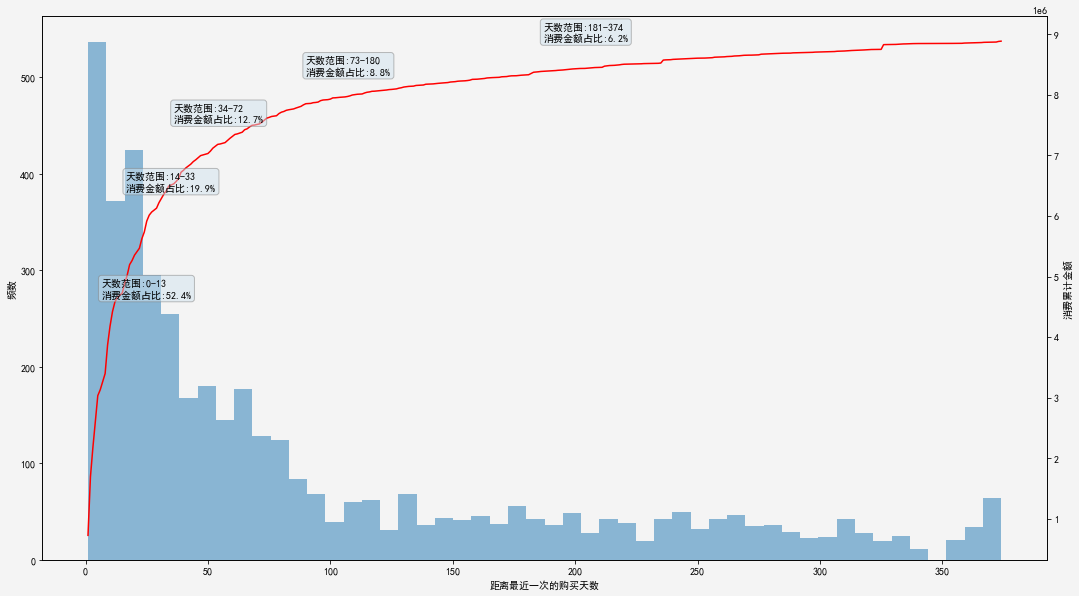

In [21]:
# 频数分布图
fig,ax = plt.subplots(figsize=(18, 10),facecolor='#f4f4f4')
ax.hist(CusDate['Recency'],bins = 50,alpha=0.5)
ax1 = ax.twinx()
ax1.plot(Monetary_sum.MonetaryValue.cumsum(),color='r')
# 文字注释
for i in range(5):
    ax1.text(
         Recency_bins[i]/2,
         Monetary_range[i],
        '天数范围:' + str(Recency_label_statistic['range_'].tolist()[i])+ '\n' + '消费金额占比:' + str(Recency_label_statistic['Monetary','per2'].tolist()[i]),
        bbox={'boxstyle': 'round',
              'edgecolor':'grey',
              'facecolor':'#d1e3ef',
              'alpha':0.5}
    )
    
ax.set_xlabel('距离最近一次的购买天数')
ax.set_ylabel('频数')
ax1.set_ylabel('消费累计金额')
ax.set_facecolor('#f4f4f4')
plt.show()

结合图表可得，距离最近一次购买天数为0-15天的客户群，其客户数量占全部客户的20%，消费金额占比53.2%。
距离最近一次购买天数越大，创造的消费金额越低。

In [22]:
# F值计算
CusDate.head()

,CustomerID,Recency,MonetaryValue,Recency_Q
0,12346,326,77183.60,1
1,12347,3,4310.00,5
2,12348,76,1797.24,2
3,12349,19,1757.55,4
4,12350,311,334.40,1


In [23]:
# 计算每个客户购买的频次---一天内多次消费算一次，按照天数计次
sale_F = sale.drop_duplicates(subset=['InvoiceNo'])   # 去重，算的是客户消费次数，订单号相同在同一天，但同一天有很多订单
CusDate_F = sale_F.groupby(['CustomerID']).agg({'InvoiceNo':'count'}).reset_index()   # 重设索引
CusDate_F.rename(columns={'InvoiceNo':'Frequency'},inplace=True)   # 重命名
CusDate_F.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [24]:
CusDate_F['Frequency'].describe()

count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: Frequency, dtype: float64

In [25]:
# 查看消费次数占比
pd.DataFrame({'count':CusDate_F['Frequency'].value_counts(),
             'percent':CusDate_F['Frequency'].value_counts()/CusDate_F['Frequency'].value_counts().sum()}).head(10)

,count,percent
1,1493,0.344168
2,835,0.192485
3,508,0.117105
4,388,0.089442
5,242,0.055786
6,172,0.039650
7,143,0.032964
8,98,0.022591
9,68,0.015675
10,54,0.012448


可以看出，消费次数为1的占比仅35%，消费次数为10的仅占比约1%。因此，为F值分箱时进行自定义分箱。

In [26]:
# 自定义边界分箱
bin_F = [1, 2, 3, 5, 8, CusDate_F['Frequency'].max()+1]
Fquartiles = pd.cut(CusDate_F['Frequency'],bin_F,labels=[1,2,3,4,5],right=False)
CusDate_F = CusDate_F.assign(Frequency_Q = Fquartiles.values)
CusDate_F.head()

,CustomerID,Frequency,Frequency_Q
0,12346,1,1
1,12347,7,4
2,12348,4,3
3,12349,1,1
4,12350,1,1


In [27]:
# 合并R,F值
CusDate = pd.merge(CusDate,CusDate_F,on='CustomerID')
# col_name = ['CustomerID','Recency','Frequency','MonetaryValue','Recency_Q','Frequency_Q']  # 重新排序列
# CusDate=CusDate.reindex(columns=col_name)
CusDate.head()

,CustomerID,Recency,MonetaryValue,Recency_Q,Frequency,Frequency_Q
0,12346,326,77183.60,1,1,1
1,12347,3,4310.00,5,7,4
2,12348,76,1797.24,2,4,3
3,12349,19,1757.55,4,1,1
4,12350,311,334.40,1,1,1


In [28]:
col_name = ['CustomerID','Recency','Frequency','MonetaryValue','Recency_Q','Frequency_Q']
CusDate=CusDate.reindex(columns=col_name)
CusDate.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q
0,12346,326,1,77183.60,1,1
1,12347,3,7,4310.00,5,4
2,12348,76,4,1797.24,2,3
3,12349,19,1,1757.55,4,1
4,12350,311,1,334.40,1,1


In [29]:
Frequency_statistic, Frequency_label_statistic, Frequency_bins = rfm_bins_statistics(CusDate['Frequency'], CusDate['Frequency_Q'], 'Freq')
Frequency_label_statistic

Freq            Monetary        range_
      count   per1          sum   per2       
label                                        
1      1493  34.4%   613989.561   6.9%    0-1
2       835  19.2%   737463.751   8.3%    2-2
3       896  20.7%  1203286.272  13.5%    3-4
4       557  12.8%  1263422.550  14.2%    5-7
5       557  12.8%  5069046.760  57.0%  8-209

In [30]:
# 各天数的消费金额之和
Monetary_sum = pd.concat([CusDate['Frequency'].value_counts().sort_index(),CusDate.groupby('Frequency').MonetaryValue.sum()], axis=1)
# 层级消费金额按照天数范围从小到大的累计之和
Monetary_range = Frequency_label_statistic['Monetary', 'sum'].cumsum().tolist()

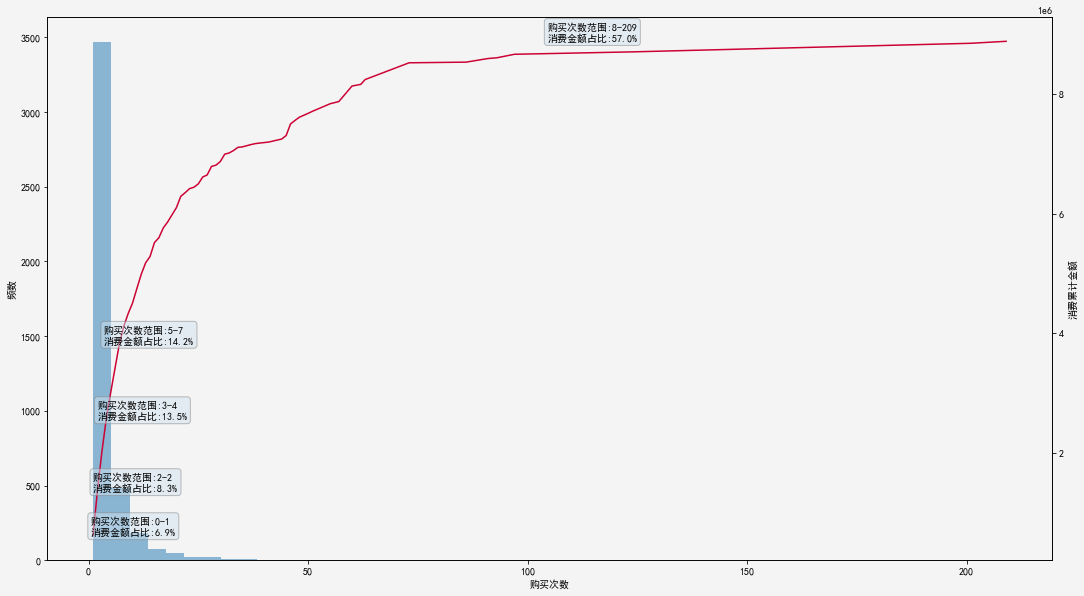

In [31]:
#频数分布图
fig,ax = plt.subplots(figsize=(18, 10),facecolor='#f4f4f4')
# 频数分布图
ax.hist(CusDate['Frequency'], bins=50, alpha=0.5)  
ax1 = ax.twinx()
ax1.plot(Monetary_sum.MonetaryValue.cumsum(), color='#cc0033')
# 文字标注
for i in range(5):
    ax1.text(
        Frequency_bins[i]/2,
        Monetary_range[i],
        '购买次数范围:' + str(Frequency_label_statistic['range_'].tolist()[i])+ '\n' + '消费金额占比:' + str(Frequency_label_statistic['Monetary','per2'].tolist()[i]),
        bbox={'boxstyle': 'round',
              'edgecolor':'grey',
              'facecolor':'#d1e3ef',
              'alpha':0.5})
ax.set_xlabel('购买次数')
ax.set_ylabel('频数')
ax1.set_ylabel('消费累计金额')
ax.set_facecolor('#f4f4f4')
plt.show()

结合图表可知，购买次数范围在8-209天的消费频率最高，消费金额占比57%。

购买频率越高，用户价值越高

In [32]:
# M分布
CusDate['MonetaryValue'].describe()

count      4338.000000
mean       2048.688081
std        8985.230220
min           3.750000
25%         306.482500
50%         668.570000
75%        1660.597500
max      280206.020000
Name: MonetaryValue, dtype: float64

In [33]:
# 分箱并依次评分
Mquartiles = pd.qcut(CusDate['MonetaryValue'], q=5,duplicates='drop',labels=[1,2,3,4,5])  # 消费金额越大越好，所以labels为顺序
CusDate = CusDate.assign(Moneytary_Q = Mquartiles.values)
CusDate.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q
0,12346,326,1,77183.60,1,1,5
1,12347,3,7,4310.00,5,4,5
2,12348,76,4,1797.24,2,3,4
3,12349,19,1,1757.55,4,1,4
4,12350,311,1,334.40,1,1,2


In [34]:
# 查看相关统计
Monetary_statistic = pd.concat([CusDate['MonetaryValue'], CusDate['Moneytary_Q']], axis=1)
Monetary_statistic.columns = ['Monetary', 'label']
Monetary_label_statistic = Monetary_statistic.groupby('label').agg({
             'label':['count',('per1', lambda x: x.count() / Monetary_statistic.label.count())],
             'Monetary':['sum',('per2', lambda x: x.sum() / Monetary_statistic.Monetary.sum())],
         }).sort_values(('Monetary','sum'),ascending = False).round(2)

Monetary_label_statistic.head()

label         Monetary      
      count per1         sum  per2
label                             
5       868  0.2  6637300.82  0.75
4       867  0.2  1213460.91  0.14
3       868  0.2   594005.68  0.07
2       867  0.2   310003.31  0.03
1       868  0.2   132438.17  0.01

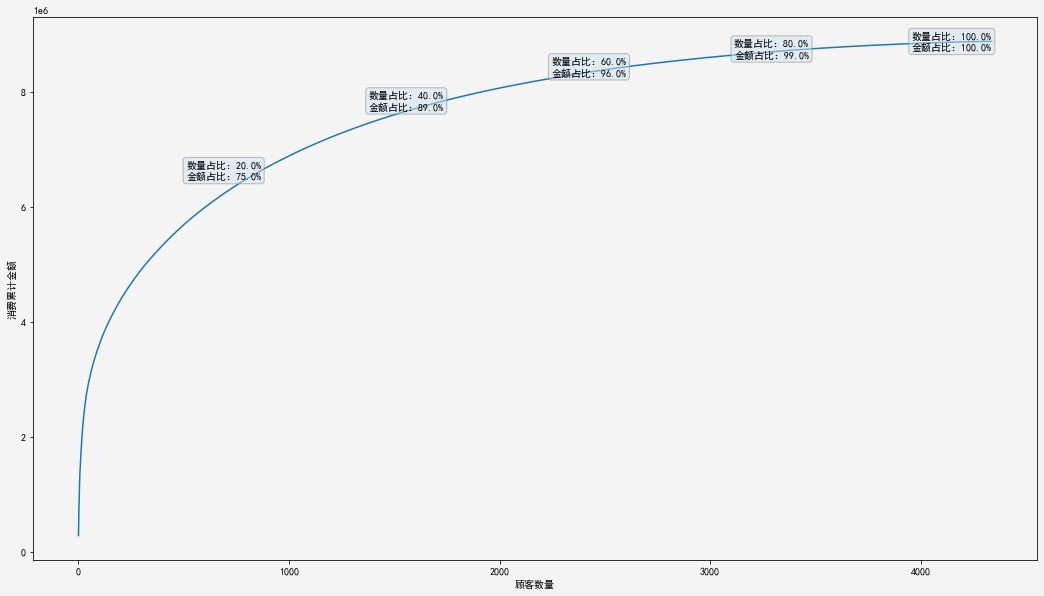

In [35]:
# 绘图
fig,ax = plt.subplots(figsize=(18, 10),facecolor='#f4f4f4')
label_count_cumsum = Monetary_label_statistic.cumsum()['label', 'count'].values
label_percent_cumsum = Monetary_label_statistic.cumsum()['label', 'per1'].values
Monetary_sum_cumsum = Monetary_label_statistic.cumsum()['Monetary', 'sum'].values
Monetary_percent_cumsum = Monetary_label_statistic.cumsum()['Monetary', 'per2'].values
ax.plot(Monetary_statistic.Monetary.sort_values(ascending=False).cumsum().values)
for i in range(5):
    ax.text(label_count_cumsum[i],
            Monetary_sum_cumsum[i],
            '数量占比：%.1f%%'%(label_percent_cumsum[i]*100)+'\n'+'金额占比：%.1f%%'%(Monetary_percent_cumsum[i]*100), 
            va='center', # 垂直对齐方式
            ha='right',  # 水平对齐方式
            bbox={
                'boxstyle': 'round',
                'edgecolor':'grey',
                'facecolor':'#d1e3ef',
                'alpha':0.5 })
ax.set_xlabel('顾客数量')
ax.set_ylabel('消费累计金额')
ax.set_facecolor('#f4f4f4')
plt.show()

由图表可知，20%的顾客数量，消费金额占比已达75%。40%的顾客数量，消费金额占比已达89%。

R,F,M分箱完毕，各分5层，各特征的头部客户均贡献了超过50%的消费。

# RFM模型搭建（方法一）

分别计算R值,F值,M值的中位数，每个指标与中位数进行比较，为每一个用户的R，F, M值进行高低维度的划分。

高用'H'表示，低用‘L’表示，高与低值针对用户的价值而言的。

R值若小于中位数，则为高，否则为低。

F值若大于中位数，则为高，否则为低。

M值若大于中位数，则为高，否则为低。

一共会得到8组分类

In [37]:
RFM_1 = CusDate.copy()
# 获取总分
RFM_1['RFM_Score'] = RFM_1[['Recency_Q','Frequency_Q','Moneytary_Q']].sum(axis=1)
RFM_1.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score
0,12346,326,1,77183.60,1,1,5,7
1,12347,3,7,4310.00,5,4,5,14
2,12348,76,4,1797.24,2,3,4,9
3,12349,19,1,1757.55,4,1,4,9
4,12350,311,1,334.40,1,1,2,4


In [38]:
# 转换数据格式
for i in RFM_1[['Recency_Q','Frequency_Q','Moneytary_Q']]:
    RFM_1[i] = RFM_1[i].astype(float)

RFM_1.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score
0,12346,326,1,77183.60,1.0,1.0,5.0,7
1,12347,3,7,4310.00,5.0,4.0,5.0,14
2,12348,76,4,1797.24,2.0,3.0,4.0,9
3,12349,19,1,1757.55,4.0,1.0,4.0,9
4,12350,311,1,334.40,1.0,1.0,2.0,4


In [39]:
# 为R值打分划分高低
R_median = RFM_1['Recency_Q'].median()
RFM_1['R_label'] = pd.cut(RFM_1['Recency_Q'],bins=[0,R_median,RFM_1['Recency_Q'].max()+1],
                            right=False,labels=['L','H'])
RFM_1.groupby(['R_label'])['CustomerID'].count()

R_label
L    1727
H    2611
Name: CustomerID, dtype: int64

In [40]:
RFM_1.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score,R_label
0,12346,326,1,77183.60,1.0,1.0,5.0,7,L
1,12347,3,7,4310.00,5.0,4.0,5.0,14,H
2,12348,76,4,1797.24,2.0,3.0,4.0,9,L
3,12349,19,1,1757.55,4.0,1.0,4.0,9,H
4,12350,311,1,334.40,1.0,1.0,2.0,4,L


In [41]:
# 为F值打分划分高低
F_median = RFM_1['Frequency_Q'].median()
RFM_1['F_label'] = pd.cut(RFM_1['Frequency_Q'],bins=[0,F_median,RFM_1['Frequency_Q'].max()+1],
                           right=False,labels=['L','H'])
RFM_1.groupby(['F_label'])['CustomerID'].count()

F_label
L    1493
H    2845
Name: CustomerID, dtype: int64

In [42]:
# 为M值打分划分高低
M_median = RFM_1['Moneytary_Q'].median()
RFM_1['M_label'] = pd.cut(RFM_1['Moneytary_Q'],bins=[0,M_median,RFM_1['Moneytary_Q'].max()+1],
                            right=False,labels=['L','H'])
RFM_1.groupby(['M_label'])['CustomerID'].count()

M_label
L    1735
H    2603
Name: CustomerID, dtype: int64

In [43]:
RFM_1.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score,R_label,F_label,M_label
0,12346,326,1,77183.60,1.0,1.0,5.0,7,L,L,H
1,12347,3,7,4310.00,5.0,4.0,5.0,14,H,H,H
2,12348,76,4,1797.24,2.0,3.0,4.0,9,L,H,H
3,12349,19,1,1757.55,4.0,1.0,4.0,9,H,L,H
4,12350,311,1,334.40,1.0,1.0,2.0,4,L,L,L


In [44]:
# 合并R,F,M值
def add_rfm(x):
    return str(x['R_label'])+str(x['F_label'])+str(x['M_label'])

RFM_1['RFM_label']=RFM_1.apply(add_rfm,axis=1)
RFM_1.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score,R_label,F_label,M_label,RFM_label
0,12346,326,1,77183.60,1.0,1.0,5.0,7,L,L,H,LLH
1,12347,3,7,4310.00,5.0,4.0,5.0,14,H,H,H,HHH
2,12348,76,4,1797.24,2.0,3.0,4.0,9,L,H,H,LHH
3,12349,19,1,1757.55,4.0,1.0,4.0,9,H,L,H,HLH
4,12350,311,1,334.40,1.0,1.0,2.0,4,L,L,L,LLL


In [46]:
# 创造综合价值变量
map_dict = {'HHH':'重要价值客户', 'HLH':'重要发展客户', 'LHH':'重要保持客户', 'LLH':'重要挽留客户','HHL':'一般价值客户', 'HLL':'一般发展客户', 'LHL':'一般保持客户', 'LLL':'一般挽留客户'}
RFM_1['CustmerLevel'] = RFM_1['RFM_label'].map(map_dict)
RFM_1.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score,R_label,F_label,M_label,RFM_label,CustmerLevel
0,12346,326,1,77183.60,1.0,1.0,5.0,7,L,L,H,LLH,重要挽留客户
1,12347,3,7,4310.00,5.0,4.0,5.0,14,H,H,H,HHH,重要价值客户
2,12348,76,4,1797.24,2.0,3.0,4.0,9,L,H,H,LHH,重要保持客户
3,12349,19,1,1757.55,4.0,1.0,4.0,9,H,L,H,HLH,重要发展客户
4,12350,311,1,334.40,1.0,1.0,2.0,4,L,L,L,LLL,一般挽留客户


In [47]:
# 用户分类结果
RFM_1.groupby(['CustmerLevel'])['CustomerID'].count()

CustmerLevel
一般价值客户     278
一般保持客户     231
一般发展客户     437
一般挽留客户     789
重要价值客户    1802
重要保持客户     534
重要发展客户      94
重要挽留客户     173
Name: CustomerID, dtype: int64

# RFM模型搭建（方法二）

分别计算出R值打分，F值打分，M值打分的平均值，将每个指标与平均值进行比较，为每一个用户的R,F,M值进行高低维度的打分

高用'H'表示，低用‘L’表示。一共会得到8组分类。

In [48]:
RFM_2 = CusDate.copy()
RFM_2['RFM_Score'] = RFM_2[['Recency_Q','Frequency_Q','Moneytary_Q']].sum(axis=1)
for i in RFM_2[['Recency_Q','Frequency_Q','Moneytary_Q']]:
    RFM_2[i] = RFM_2[i].astype(float)
RFM_2.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score
0,12346,326,1,77183.60,1.0,1.0,5.0,7
1,12347,3,7,4310.00,5.0,4.0,5.0,14
2,12348,76,4,1797.24,2.0,3.0,4.0,9
3,12349,19,1,1757.55,4.0,1.0,4.0,9
4,12350,311,1,334.40,1.0,1.0,2.0,4


In [49]:
# 分别求均值
mean_R_score = RFM_2['Recency_Q'].mean()
mean_F_score = RFM_2['Frequency_Q'].mean()
mean_M_score = RFM_2['Moneytary_Q'].mean()
print(mean_R_score,mean_F_score,mean_M_score)

3.0064545873674504 2.50437989857077 3.0


In [63]:
# R，F，M高低划分

In [50]:
RFM_2['R_label'] = pd.cut(RFM_2['Recency_Q'],bins=[0,mean_R_score,6],
                            right=True,labels=['L','H'])  
RFM_2['F_label'] = pd.cut(RFM_2['Frequency_Q'],bins=[0,mean_R_score,6],
                            right=True,labels=['L','H'])  
RFM_2['M_label'] = pd.cut(RFM_2['Moneytary_Q'],bins=[0,mean_M_score,6],
                            right=True,labels=['L','H'])  
RFM_2.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score,R_label,F_label,M_label
0,12346,326,1,77183.60,1.0,1.0,5.0,7,L,L,H
1,12347,3,7,4310.00,5.0,4.0,5.0,14,H,H,H
2,12348,76,4,1797.24,2.0,3.0,4.0,9,L,L,H
3,12349,19,1,1757.55,4.0,1.0,4.0,9,H,L,H
4,12350,311,1,334.40,1.0,1.0,2.0,4,L,L,L


In [51]:
# 合并
def score_label_segment(x):
    return str(x['R_label'])+str(x['F_label'])+str(x['M_label'])

RFM_2['RFM_label']=RFM_2.apply(score_label_segment,axis=1)

# 创造总和价值变量
map_dict = {'HHH':'重要价值客户', 'HLH':'重要发展客户', 'LHH':'重要保持客户', 'LLH':'重要挽留客户','HHL':'一般价值客户', 'HLL':'一般发展客户', 'LHL':'一般保持客户', 'LLL':'一般挽留客户'}
RFM_2['CustmerLevel'] = RFM_2['RFM_label'].map(map_dict)
RFM_2.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,RFM_Score,R_label,F_label,M_label,RFM_label,CustmerLevel
0,12346,326,1,77183.60,1.0,1.0,5.0,7,L,L,H,LLH,重要挽留客户
1,12347,3,7,4310.00,5.0,4.0,5.0,14,H,H,H,HHH,重要价值客户
2,12348,76,4,1797.24,2.0,3.0,4.0,9,L,L,H,LLH,重要挽留客户
3,12349,19,1,1757.55,4.0,1.0,4.0,9,H,L,H,HLH,重要发展客户
4,12350,311,1,334.40,1.0,1.0,2.0,4,L,L,L,LLL,一般挽留客户


In [52]:
# 用户分类结果
RFM_2.groupby(['CustmerLevel'])['CustomerID'].count()

CustmerLevel
一般价值客户      42
一般保持客户      30
一般发展客户     643
一般挽留客户    1888
重要价值客户     789
重要保持客户     253
重要发展客户     274
重要挽留客户     419
Name: CustomerID, dtype: int64

# 两种求解RFM模型的方法比较

In [55]:
# 方法一：
rfm1=RFM_1.groupby(['CustmerLevel']).agg({'CustomerID':[('总数','count'),('占比',lambda x: "%.1f"%((x.sum()/ RFM_1['CustomerID'].sum()*100))+'%')],
                                          'RFM_Score':'mean'
                                            }).sort_values(('CustomerID','总数'),ascending=False)
rfm1

CustomerID         RFM_Score
                     总数     占比       mean
CustmerLevel                             
重要价值客户             1802  41.3%  12.031077
一般挽留客户              789  18.3%   3.718631
重要保持客户              534  12.2%   8.308989
一般发展客户              437  10.2%   6.013730
一般价值客户              278   6.5%   7.935252
一般保持客户              231   5.4%   5.575758
重要挽留客户              173   3.9%   5.867052
重要发展客户               94   2.1%   7.787234

In [53]:
# 方法二
# 各分类用户人数
rfm2=RFM_2.groupby(['CustmerLevel']).agg({'CustomerID':[('总数','count'),('占比',lambda x: "%.1f"%((x.sum()/ RFM_2['CustomerID'].sum()*100))+'%')],
                                          'RFM_Score':'mean'
                                            }).sort_values(('CustomerID','总数'),ascending=False)
rfm2

CustomerID         RFM_Score
                     总数     占比       mean
CustmerLevel                             
一般挽留客户             1888  43.8%   5.289725
重要价值客户              789  18.1%  13.923954
一般发展客户              643  15.0%   8.468118
重要挽留客户              419   9.4%   8.856802
重要发展客户              274   6.2%  11.412409
重要保持客户              253   5.9%  11.525692
一般价值客户               42   1.0%  11.380952
一般保持客户               30   0.7%   9.000000

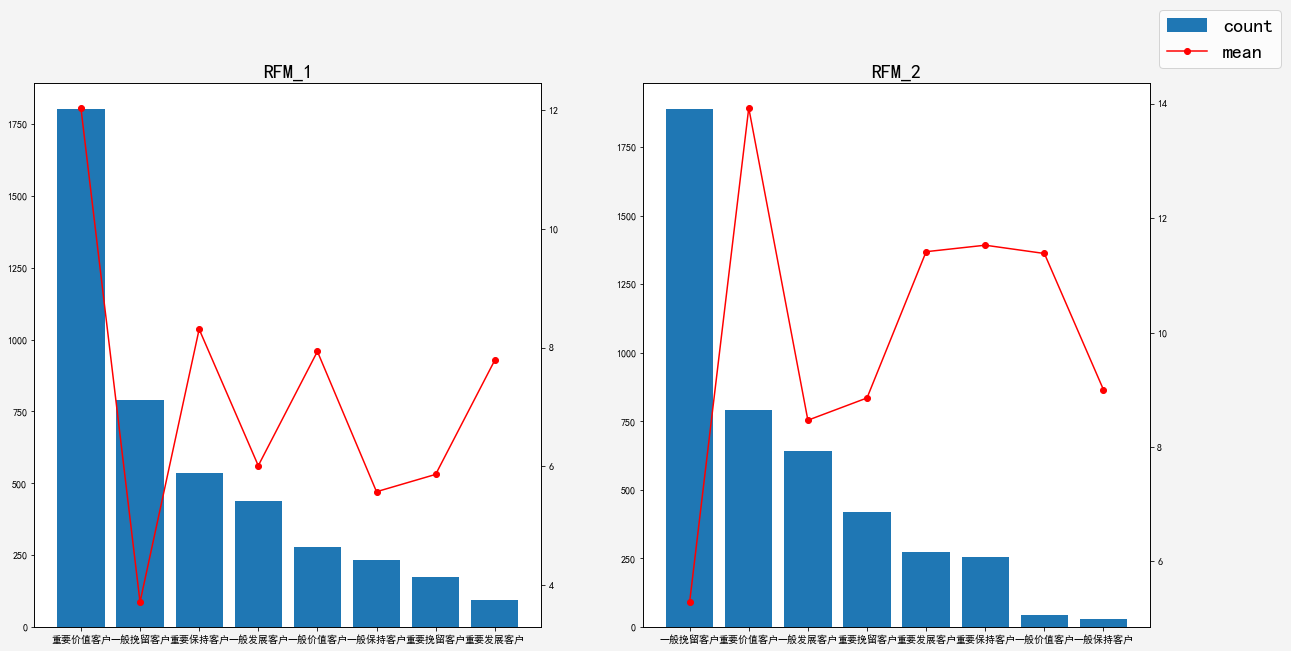

In [56]:
# 可视化 
fig = plt.figure(figsize=(20,10),facecolor='#f4f4f4')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
ax1 = fig.add_subplot(121)
ax1.bar(rfm1.index,rfm1['CustomerID','总数'].values,label="count")
ax1.set_title("RFM_1",fontsize=20)
ax2=ax1.twinx()
ax2.plot(rfm1.index,rfm1['RFM_Score','mean'].values,marker="o",c="r",label="mean")
fig.legend(fontsize=20)
#fig.legend(loc="upper right")
ax3 = fig.add_subplot(122)
ax3.bar(rfm2.index,rfm2['CustomerID','总数'].values,label="count")
ax3.set_title("RFM_2",fontsize=20)
ax4=ax3.twinx()
ax4.plot(rfm2.index,rfm2['RFM_Score','mean'].values,marker="o",c="r",label="mean")

方法一采用中位数来搭建RFM模型，重要价值客户数量最多，其次是一般挽留客户，一般保持用户最少，仅有30人。

方法二采用平均值来搭建RFM模型。一般挽留客户数量最多，其次是重要价值用户，一般价值客户仅有42人，一般保持客户仅有30人

类别间用户数量差异相对明显。

方法一得到的用户分类相对合理些。在现实中，应结合业务对模型的好坏进行评价。

In [57]:
# 这里以RFM模型搭建（方法一）来进行以下分析
# 计算每类客户的消费总金额，订单数量，购买的商品总量等
data_temp1 = sale_F.groupby(['CustomerID']).agg({'InvoiceNo':'count'}).reset_index()   
data_temp2 = sale.groupby(['CustomerID']).agg({'TotalSum':'sum','Quantity':'sum'}).reset_index() 
RFM_data = pd.concat([RFM_1['CustmerLevel'],data_temp2,data_temp1['InvoiceNo'],RFM_1['Recency'],RFM_1['Frequency']],axis=1)
RFM_data.columns = ['客户等级','客户编号','消费金额', '购买商品总量', '订单总量', '最近消费天数','消费次数']
RFM_data.head()

,客户等级,客户编号,消费金额,购买商品总量,订单总量,最近消费天数,消费次数
0,重要挽留客户,12346,77183.60,74215,1,326,1
1,重要价值客户,12347,4310.00,2458,7,3,7
2,重要保持客户,12348,1797.24,2341,4,76,4
3,重要发展客户,12349,1757.55,631,1,19,1
4,一般挽留客户,12350,334.40,197,1,311,1


In [58]:
# 定义一个统计函数
def customer_level_statistic(customer_data):
    customer_level = (customer_data
                 .groupby('客户等级')
                 .agg({
                        '消费金额':[('均值', 'mean'),
                                    ('总量', 'sum'),
                                    ('占比', lambda x: "%.1f"%((x.sum()/ customer_data['消费金额'].sum()*100))+'%')], 
                        '购买商品总量':[('均值', 'mean'),
                                        ('总量', 'sum'),
                                       ('占比', lambda x:"%.1f"%((x.sum()/ customer_data['购买商品总量'].sum()*100))+'%')],
                        '订单总量':[('均值', 'mean'),
                                    ('总量', 'sum'),
                                    ('占比', lambda x:"%.1f"%((x.sum()/ customer_data['订单总量'].sum()*100))+'%')],
                        '客户等级':[('总量', 'count'),
                                    ('占比', lambda x:"%.1f"%((x.count()/ customer_data['客户等级'].count()*100))+'%')],
                        '最近消费天数':[('均值','mean')],
                        '消费次数':[('均值','mean')],
                    })
                 .sort_values(('消费金额','总量'),ascending=False)
                 .assign(客单价 = lambda x : x['消费金额','总量'] / x['订单总量','总量'])
                 .round(1)
                 )
    customer_level.columns = pd.Index(customer_level.columns[:-1].tolist() + [('客单价','均值')])
    return customer_level

In [59]:
RFM_level_statistic = customer_level_statistic(RFM_data)
RFM_level_statistic

消费金额                    购买商品总量                 订单总量                \
            均值         总量     占比      均值       总量     占比   均值     总量     占比   
客户等级                                                                          
重要价值客户  4031.7  7265191.1  81.7%  2312.0  4166210  80.9%  7.7  13937  75.2%   
重要保持客户  1586.9   847389.0   9.5%   898.1   479572   9.3%  3.6   1901  10.3%   
重要挽留客户  1402.0   242548.2   2.7%  1024.6   177255   3.4%  1.0    173   0.9%   
一般挽留客户   224.6   177177.6   2.0%   133.5   105359   2.0%  1.0    789   4.3%   
一般发展客户   239.4   104624.7   1.2%   163.5    71443   1.4%  1.0    437   2.4%   
重要发展客户   953.6    89639.1   1.0%   526.5    49487   1.0%  1.0     94   0.5%   
一般价值客户   319.2    88741.3   1.0%   194.7    54114   1.1%  2.3    650   3.5%   
一般保持客户   311.2    71897.9   0.8%   210.2    48562   0.9%  2.4    551   3.0%   

        客户等级        最近消费天数 消费次数     客单价  
          总量     占比     均值   均值      均值  
客户等级                                     
重要价值客户  1802  41.5%   23.7  7.7   521.3  
重要保持客户   534  12.3%  144.4  3.6   445.8  
重要挽留客户   173   4.0%  190.0  1.0  1402.0  
一般挽留客户   789  18.2%  230.1  1.0   224.6  
一般发展客户   437  10.1%   37.6  1.0   239.4  
重要发展客户    94   2.2%   41.9  1.0   953.6  
一般价值客户   278   6.4%   28.6  2.3   136.5  
一般保持客户   231   5.3%  178.0  2.4   130.5

In [60]:
#可视化
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from matplotlib import cm 

def customer_level_pie(data_level):
    fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi=300,facecolor='#f4f4f4')
    cs=cm.Set1(np.arange(40)) 
    columns_list = [['消费金额', '购买商品总量'], ['订单总量', '客户等级']]
    
    for i in [0,1]:
        for j in [0,1]:
            values_p = data_level[columns_list[i][j],'总量'].values
            patches,texts,autotexts=axes[i][j].pie(values_p,autopct="%.2f%%",labels=data_level.index,colors=cs,radius=1.1,pctdistance=0.9)
            for autotext,text in zip(autotexts,texts):
                autotext.set_color("w")
                autotext.set_size(6)
                text.set_size(5)
            axes[i][j].set_title(columns_list[i][j]+"对比",fontsize=10)
            plt.axis('equal')
            axes[i][j].set_facecolor('#f4f4f4')
    plt.show()

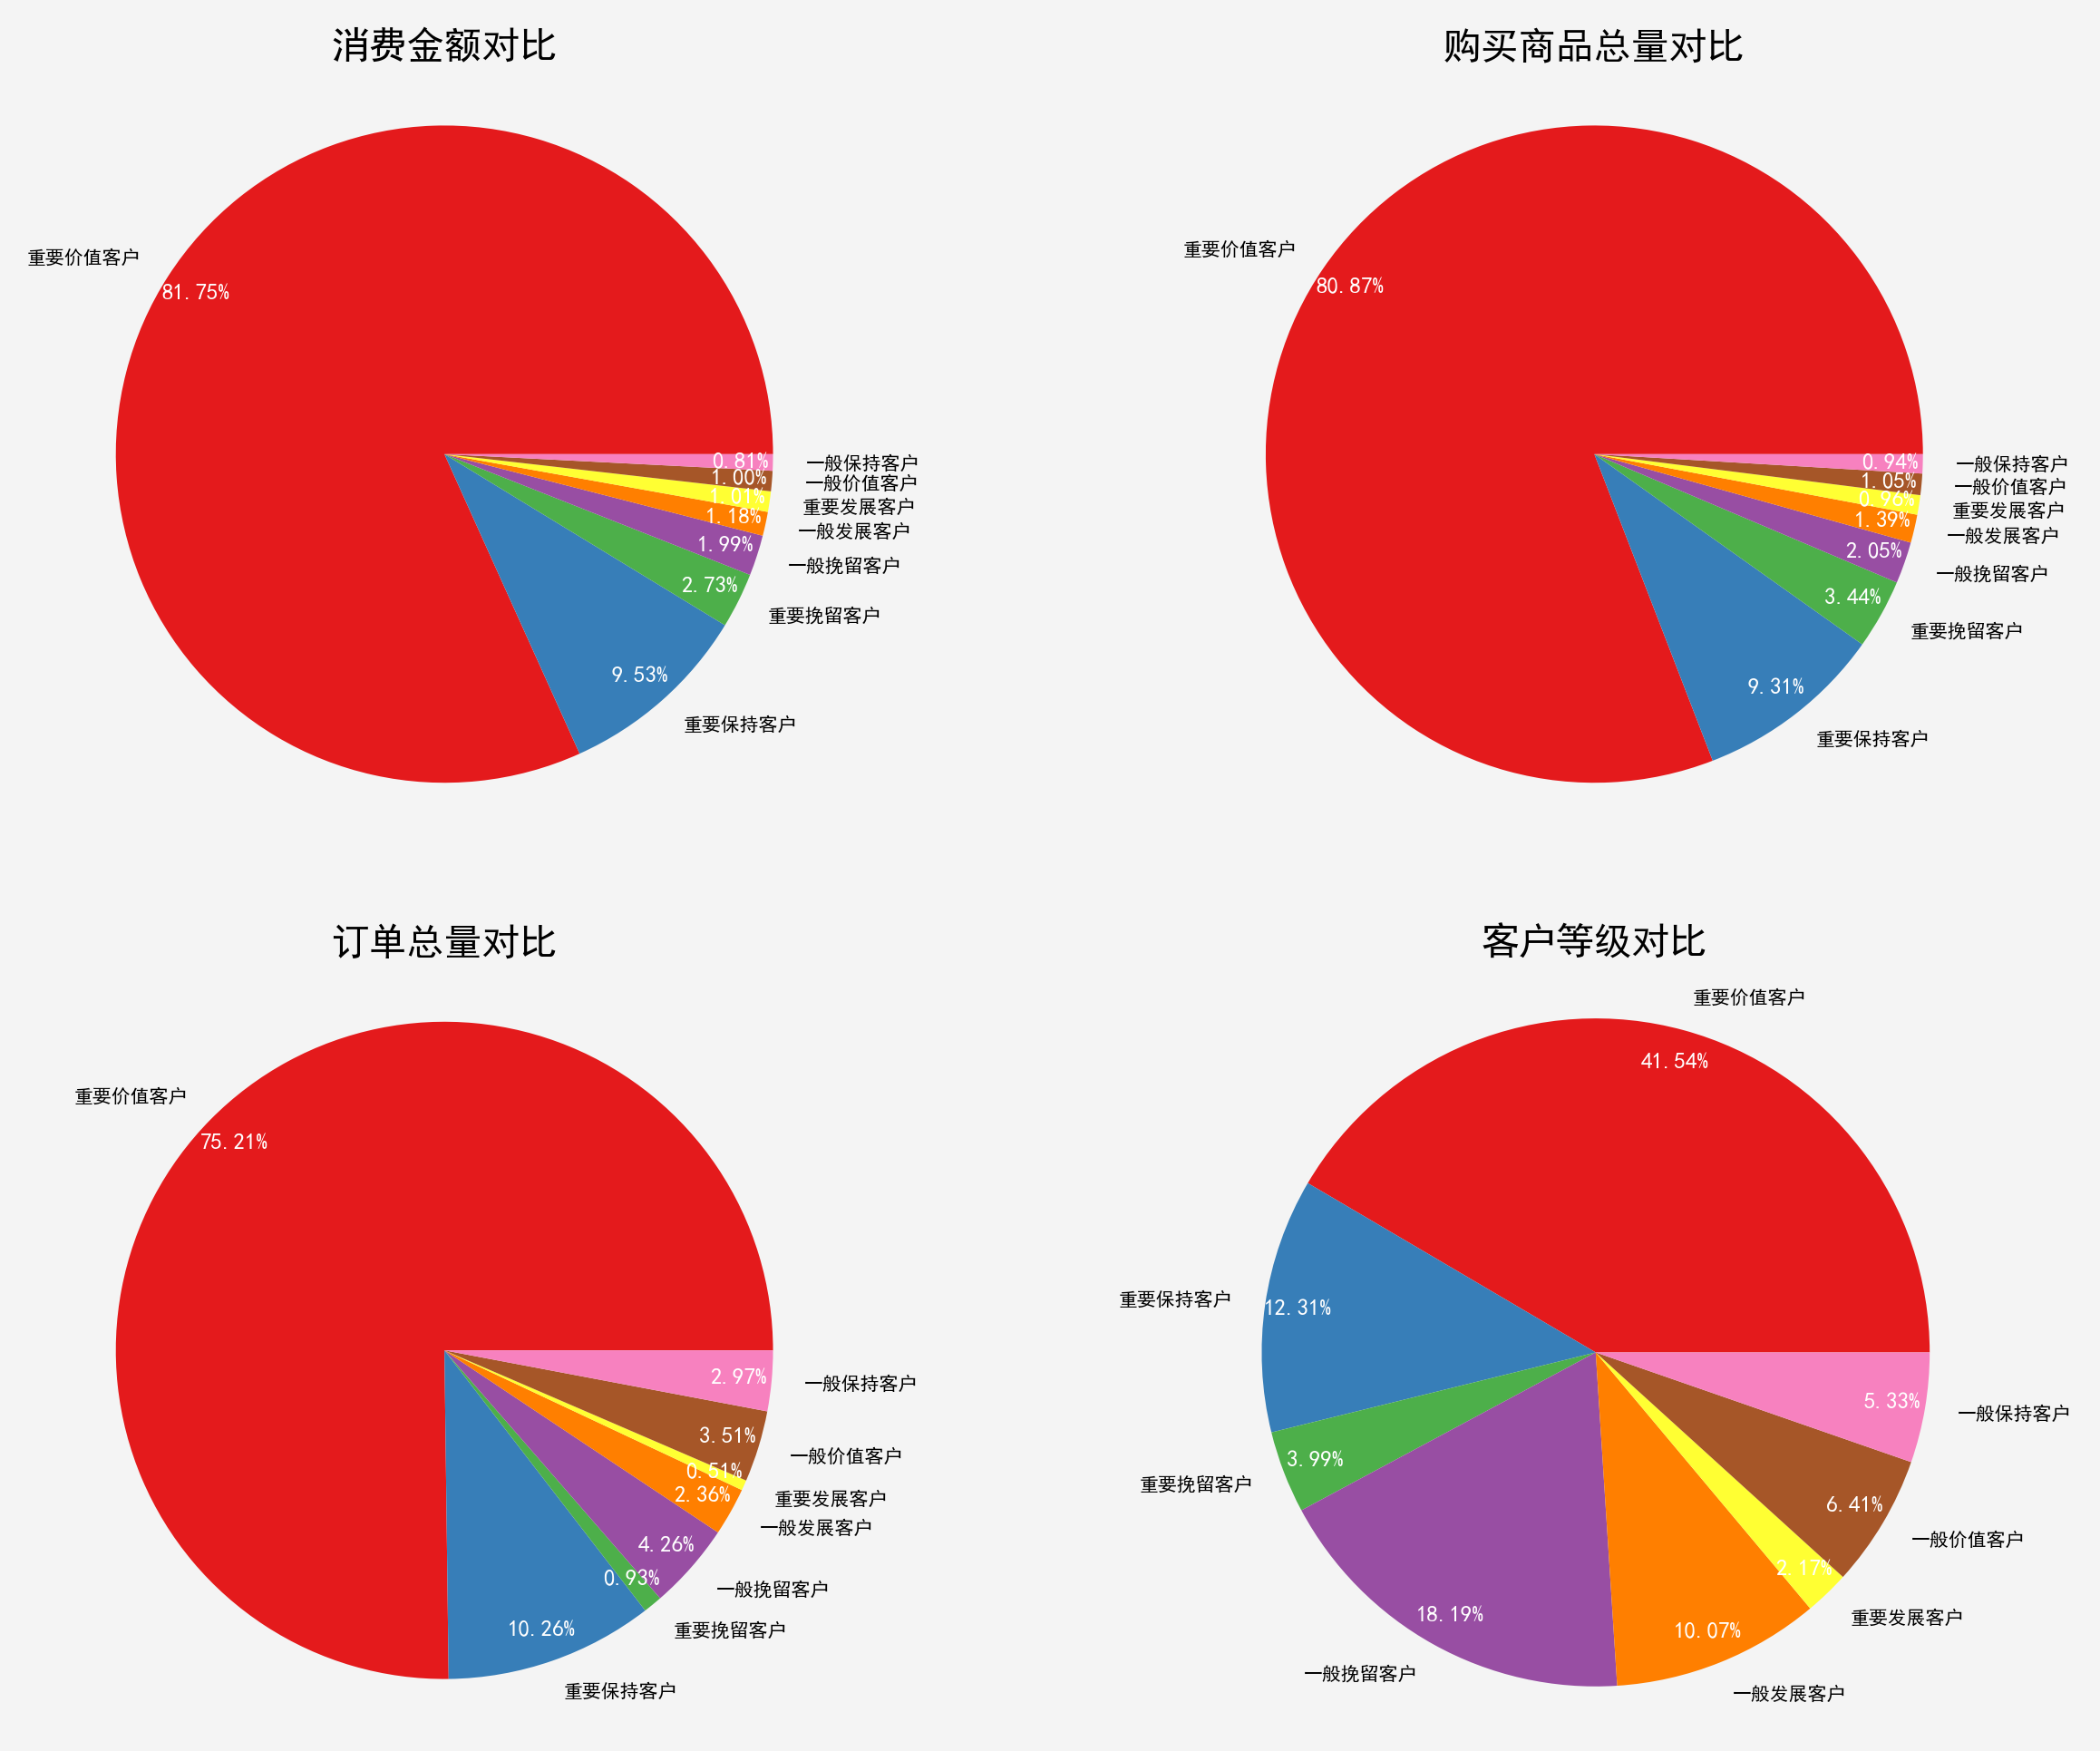

In [61]:
customer_level_pie(RFM_level_statistic)

In [62]:
# 绘制各指标均值对比图
# 条形图
def customer_level_barh(data_level):
    fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), dpi=300,facecolor='#f4f4f4')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

    columns_list = [['消费金额', '客单价'], ['最近消费天数', '消费次数']]
    for i in [0,1]:
        for j in [0,1]:
            index = data_level[columns_list[i][j], '均值'].sort_values().index
            values = data_level[columns_list[i][j], '均值'].sort_values().values
            ax[i][j].barh(index, values)
            # 通过text可以在Axes对象上添加文本。只需要指定x和y的坐标以及文字内容就可以了。
            for k in range(len(data_level)):
                ax[i][j].text(values[k],k,values[k],size=10 )  

            ax[i][j].set_title(columns_list[i][j]+'均值对比')
            ax[i][j].set_facecolor('#f4f4f4')

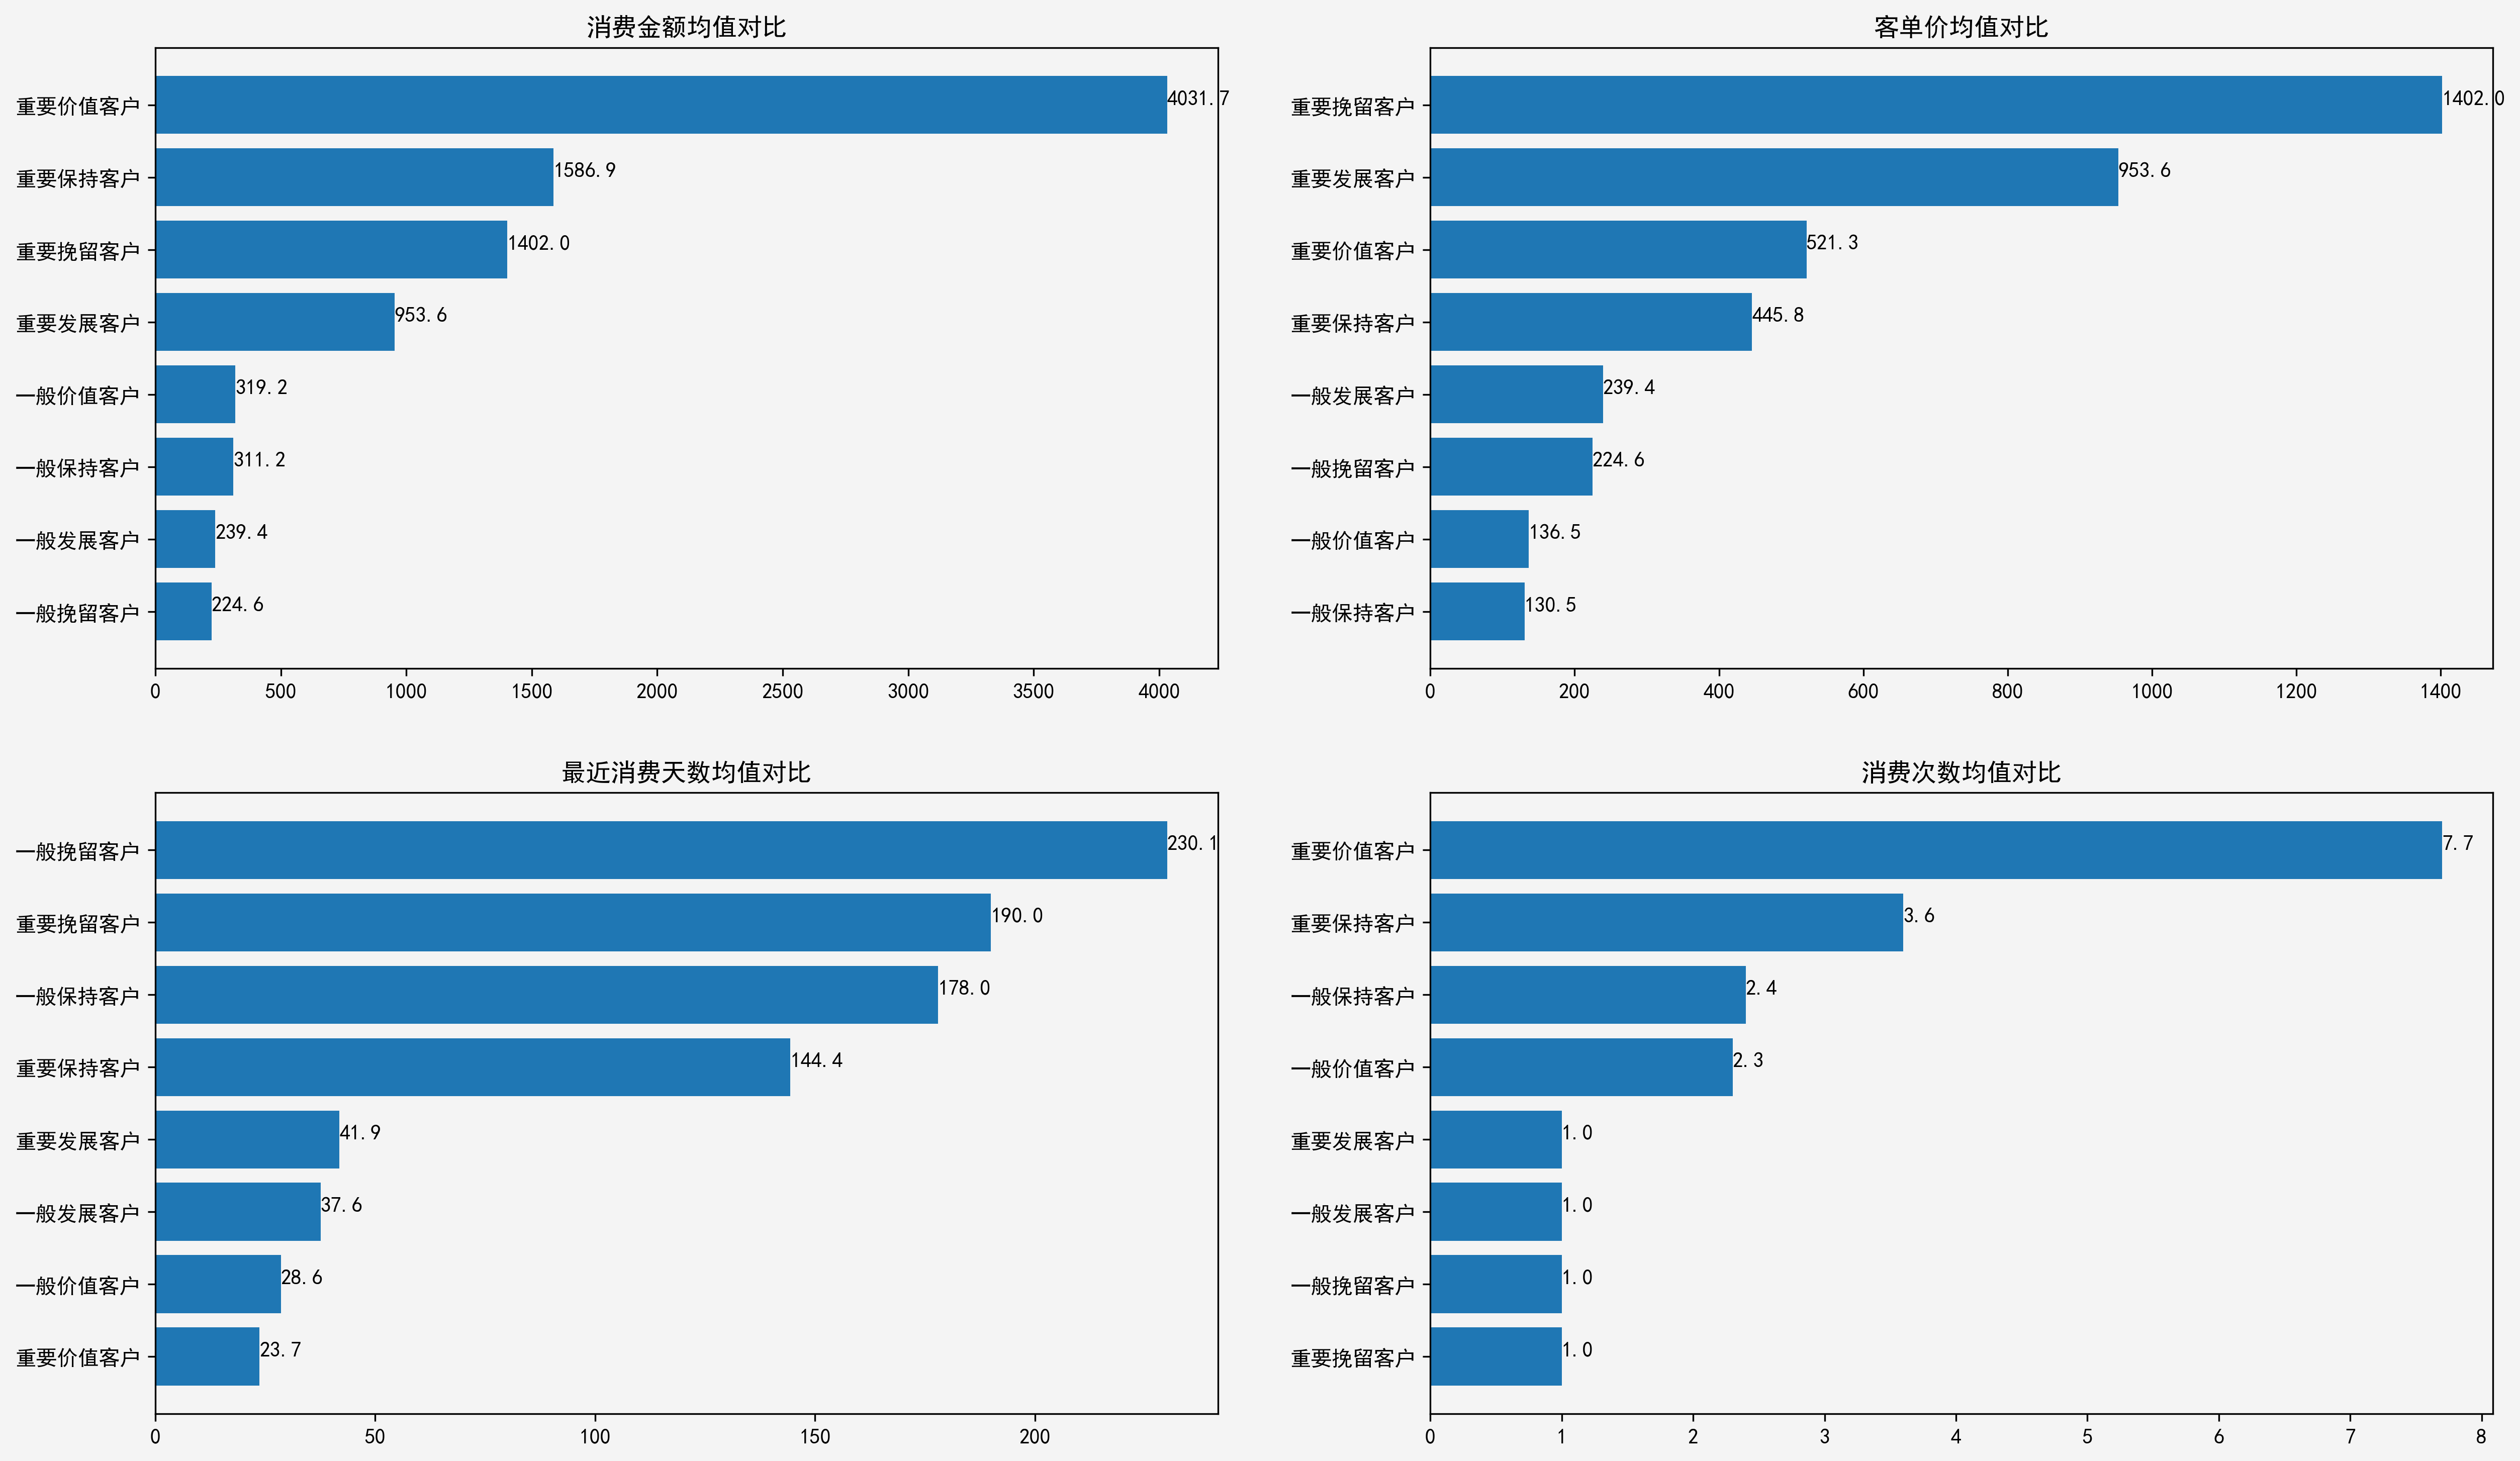

In [63]:
customer_level_barh(RFM_level_statistic)

根据R,F,M高低区分的8类客户，可以根据其特点，给出针对性的营销策略

# K-means聚类寻找价值用户

In [64]:
# 选择特征值和样本数据
# 合并数据
RFM = CusDate[['CustomerID','Recency','Frequency','MonetaryValue']]
RFM.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,326,1,77183.60
1,12347,3,7,4310.00
2,12348,76,4,1797.24
3,12349,19,1,1757.55
4,12350,311,1,334.40


In [ ]:
# 特征工程

In [65]:
RFM.describe()

,CustomerID,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,93.059474,4.272015,2048.688081
std,1721.808492,100.012264,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.750000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

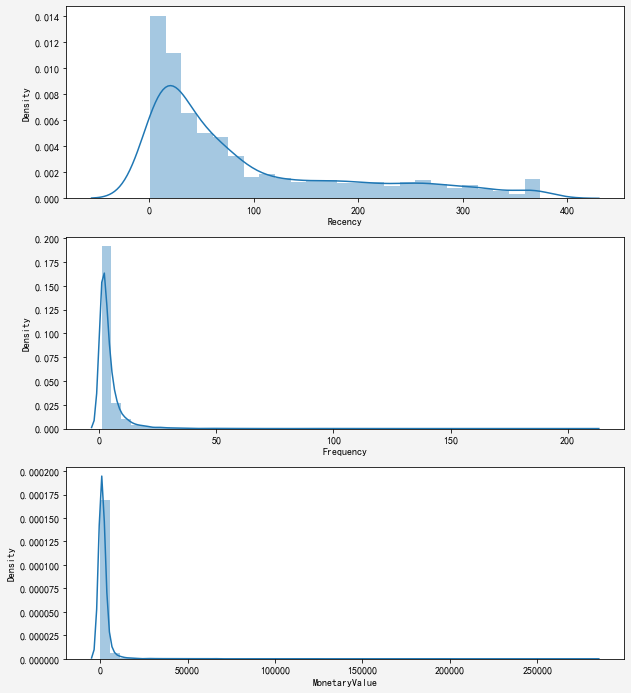

In [66]:
# 对于R,F,M值分别绘制频数图，来查看数据的正态性
import matplotlib.pyplot as plt
import seaborn as sns
# 魔法函数，可以在IPython编译器里直接使用，作用是内嵌画图，省略掉plt.show()这一步，直接显示图像。
# %matplotlib inline  
plt.rcParams['axes.unicode_minus'] = False  
# 分别绘制频数图
f,ax = plt.subplots(3,1,figsize=(10, 12),facecolor='#f4f4f4' )
plt.subplot(3,1,1); sns.distplot(RFM['Recency'],label='Recency')
plt.subplot(3,1,2); sns.distplot(RFM['Frequency'],label='Frequency')
plt.subplot(3,1,3); sns.distplot(RFM['MonetaryValue'],label='MonetaryValue')

可以看出，数据均呈长尾分布。

K-means算法对数据的要求：

（1）变量值是对称分布的

（2）变量进行归一化处理，平均值和方差均相同

由R,F,M三个变量的频数分布图可知，变量值分布不满足对称性，可以使用对数变换解决

In [67]:
# 数据预处理
# 将等于0的值替换成1，否则log变换后会出现无穷大的情况
RFM.Recency[RFM['Recency']==0]=0.01
RFM.Frequency[RFM['Frequency']==0]=0.01
RFM.MonetaryValue[RFM['MonetaryValue']==0]=0.01
RFM_log = RFM[['Recency','Frequency','MonetaryValue']].apply(np.log,axis=1).round(3)
RFM.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,326,1,77183.60
1,12347,3,7,4310.00
2,12348,76,4,1797.24
3,12349,19,1,1757.55
4,12350,311,1,334.40


<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

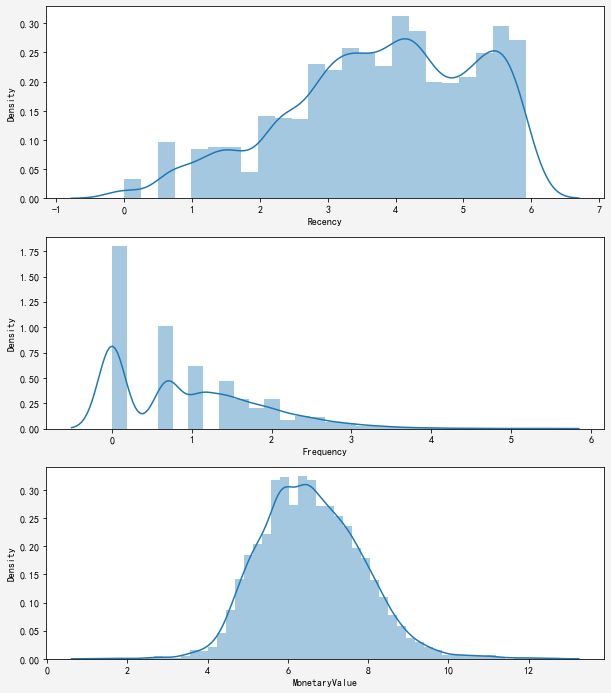

In [68]:
# 绘制频数分布图
f,ax = plt.subplots(3,1,figsize=(10,12),facecolor='#f4f4f4')
plt.subplot(3,1,1); sns.distplot(RFM_log['Recency'],label='Recency')
plt.subplot(3,1,2); sns.distplot(RFM_log['Frequency'],label='Frequency')
plt.subplot(3,1,3); sns.distplot(RFM_log['MonetaryValue'],label='MonetaryValue')

In [ ]:
# 由图上可以看出相较于之前更符合正态分布

In [82]:
# 标准化处理
# K-Means算法的本质是基于欧式距离的数据划分算法，均值和方差大的维度将对数据的聚类产生决定性影响。
# 另外使用标准化对数据进行预处理可以减小不同量纲的影响。

In [69]:
from sklearn.preprocessing import StandardScaler   # 标准化
scaler = StandardScaler()
scaler.fit(RFM_log)
RFM_normalization = scaler.transform(RFM_log)

In [70]:
rfm_data = pd.DataFrame(RFM_normalization,columns = ['R', 'F', 'M'])
rfm_data.head()

,R,F,M
0,1.435500,-1.048593,3.700239
1,-1.953082,1.111983,1.413494
2,0.383073,0.490234,0.719941
3,-0.619479,-1.048593,0.702503
4,1.401527,-1.048593,-0.613267


# Kmeans建模

In [71]:
# k值选取
from sklearn.cluster import KMeans

ks = range(1,9)
inertias=[]
for k in  ks:
    kc = KMeans(n_clusters=k, init='k-means++', random_state = 1)  # 设置模型参数
    kc.fit(rfm_data)
    inertias.append(kc.inertia_) # 每个样本点到距离他们最近簇心的均方距离，又叫做“簇内平方和”
    print('k=',k,' 迭代次数',kc.n_iter_)  # n_iter_实际的迭代次数

k= 1  迭代次数 2
k= 2  迭代次数 11
k= 3  迭代次数 14
k= 4  迭代次数 22
k= 5  迭代次数 11
k= 6  迭代次数 31
k= 7  迭代次数 20
k= 8  迭代次数 29


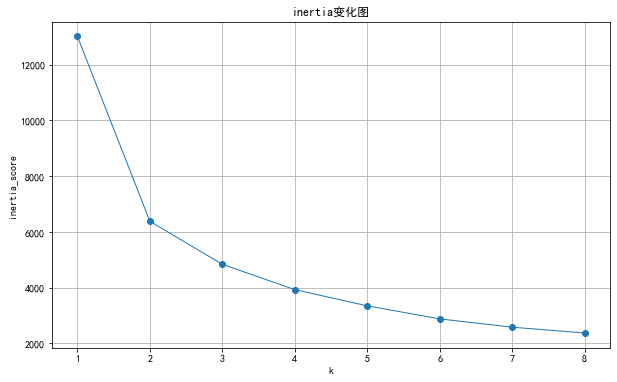

In [72]:
# 绘制每个k值对应的inertia_
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(ks,inertias,'-o',linewidth=1)
plt.xlabel('k')
plt.ylabel('inertia_score')
plt.title('inertia变化图')
plt.grid()
plt.show()

当k=2时出现了明显的拐点，但实际业务将用户分成两类可能精确度不够高，所以继续使用轮廓系数来评估

In [73]:
# 轮廓系数
# 使用轮廓系数评估聚类效果—轮廓系数的区间为：[-1, 1]。
# -1代表分类效果差，1代表分类效果好。0代表聚类重叠，没有很好的划分聚类。
from sklearn import metrics

label_list = []
silhouette_score_list = []
kw = range(2,9)
for k in kw:
    model = KMeans(n_clusters = k,random_state=1 )
    kmeans = model.fit(RFM_normalization)
    silhouette_score = metrics.silhouette_score(RFM_normalization, kmeans.labels_)  # 轮廓系数
    silhouette_score_list.append(silhouette_score)
    label_list.append({k: kmeans.labels_})
    print('k:',k,'   silhouette_score=',silhouette_score)

k: 2    silhouette_score= 0.4315133410597809
k: 3    silhouette_score= 0.33440084623135863
k: 4    silhouette_score= 0.3319677383616976
k: 5    silhouette_score= 0.306613809507798
k: 6    silhouette_score= 0.3112594555493001
k: 7    silhouette_score= 0.3097248241324737
k: 8    silhouette_score= 0.2779316511245861


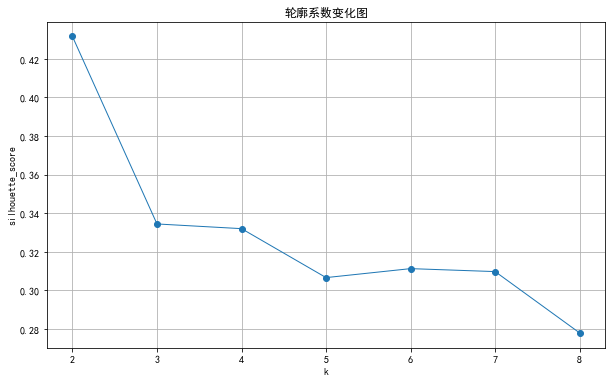

In [74]:
# 绘图   
fig,ax = plt.subplots(figsize=(10,6))
#ax,plot(kw,silhouette_score_list,'-o',linewidth=1)
plt.plot(kw,silhouette_score_list,'-o',linewidth=1)
plt.xlabel('k')
plt.ylabel("silhouette_score") 
plt.title('轮廓系数变化图')
plt.grid()
plt.show()

观察轮廓系数可得，分为2类效果最好，3-4类效果次之

In [75]:
# calinski-harabaz Index：适用于实际类别信息未知的情况，为群内离散与簇间离散的比值，值越大聚类效果越好。
from sklearn import metrics
calinski_list = []
kk = range(2,9)
for k in kk:
    y_pred = KMeans(n_clusters=k, random_state=1).fit_predict(RFM_normalization) #k必须大于1
    calinski = metrics.calinski_harabasz_score(RFM_normalization, y_pred)
    calinski_list.append(calinski)
    print('k:',k,'   calinski=',calinski)

k: 2    calinski= 4504.811955930066
k: 3    calinski= 3659.988422413544
k: 4    calinski= 3338.0120334545963
k: 5    calinski= 3123.8189533710492
k: 6    calinski= 3044.2939728100755
k: 7    calinski= 2913.0678863652265
k: 8    calinski= 2767.3654458500664


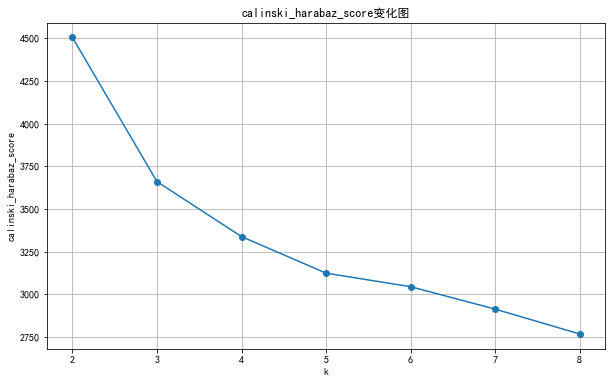

In [76]:
# 绘图   
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(kk,calinski_list,'-o')
plt.xlabel('k')
plt.ylabel("calinski_harabaz_score") 
plt.title('calinski_harabaz_score变化图')
plt.grid()
plt.show()

分为2类效果最好，其次是3类，效果随k增大而变差
综上，分为2类的效果最好，但是不符合业务诉求，分3类效果次之，接下来选择k=3进行验证

In [77]:
# 模型计算--分为3类
kc = KMeans(n_clusters=3, random_state=1)
kc.fit(rfm_data)
#  每个样本对应的类簇标签，顺序与样本原始顺序一致
cluster_label = kc.labels_
RFM['K-means_label'] = cluster_label
RFM.head()

,CustomerID,Recency,Frequency,MonetaryValue,K-means_label
0,12346,326,1,77183.60,1
1,12347,3,7,4310.00,2
2,12348,76,4,1797.24,1
3,12349,19,1,1757.55,1
4,12350,311,1,334.40,0


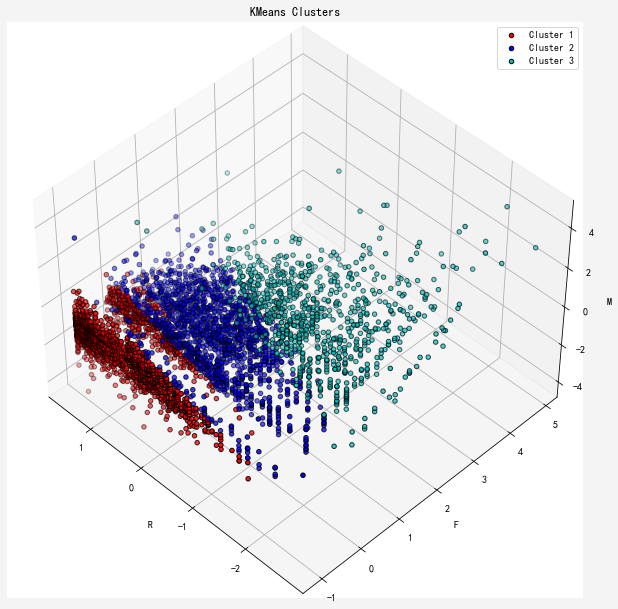

In [78]:
# 效果可视化
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure(1, figsize=(12, 8),facecolor='#f4f4f4')
ax1 = Axes3D(fig1, rect = [0,0,.95, 1], elev = 45, azim = -45)
c1_ax1 = ax1.scatter(rfm_data['R'][cluster_label == 0], rfm_data['F'][cluster_label == 0], 
                     rfm_data['M'][cluster_label == 0], edgecolor = 'k', color = 'r')
c2_ax1 = ax1.scatter(rfm_data['R'][cluster_label == 1], rfm_data['F'][cluster_label == 1], 
                     rfm_data['M'][cluster_label == 1], edgecolor = 'k', color = 'b')
c3_ax1 = ax1.scatter(rfm_data['R'][cluster_label == 2], rfm_data['F'][cluster_label == 2], 
                     rfm_data['M'][cluster_label == 2], edgecolor = 'k', color = 'c')
ax1.legend([c1_ax1,c2_ax1,c3_ax1], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax1.invert_xaxis()
ax1.set_xlabel('R')
ax1.set_ylabel('F')
ax1.set_zlabel('M')
ax1.set_title('KMeans Clusters')
plt.show()
#ax1.dist = 12

In [79]:
# 分析
# 选出每个客户的消费总金额，订单总量，购买的商品总数
data_temp3 = sale_F.groupby(['CustomerID']).agg({'InvoiceNo':'count'}).reset_index()   
data_temp4 = sale.groupby(['CustomerID']).agg({'TotalSum':'sum','Quantity':'sum'}).reset_index() 
kmeans_data = pd.concat([RFM['K-means_label'],data_temp4,data_temp3['InvoiceNo'],RFM['Recency'],RFM['Frequency']],axis=1)
kmeans_data.columns = ['客户等级','客户编号','消费金额', '购买商品总量', '订单总量', '最近消费天数','消费次数']
rfm_level  = customer_level_statistic(kmeans_data)
rfm_level

消费金额                    购买商品总量                  订单总量                \
          均值         总量     占比      均值       总量     占比    均值     总量     占比   
客户等级                                                                         
2     7304.5  6201531.9  69.8%  4103.5  3483843  67.6%  12.5  10589  57.1%   
1     1242.3  2074694.3  23.3%   775.9  1295835  25.2%   3.4   5644  30.5%   
0      335.9   610982.7   6.9%   204.7   372324   7.2%   1.3   2299  12.4%   

      客户等级        最近消费天数  消费次数    客单价  
        总量     占比     均值    均值     均值  
客户等级                                   
2      849  19.6%   15.4  12.5  585.7  
1     1670  38.5%   54.8   3.4  367.6  
0     1819  41.9%  164.4   1.3  265.8

观察可知：

2类客户数量占比19.5%，是三类客户中人数占比最少，但是创造了近70%的消费金额，57.1%的订单总量，最近消费天数平均为半个月，消费次数平均在13次左右，客单价也是3类客户中最高的，是主要的消费客户。

1类客户数量占比38.5%，消费金额占比23.3%，订单总量占比30.5%，对平台具有一定的价值，其最近的消费天数平均在3个月内，客单价较高，消费次数较低，可以采取一定的措施提高消费频率来挽回此类客户。

0类客户数量占比41.9%，总人数最多，仅创造6.9%的消费金额，12.4% 的订单总量，最近消费天数均值已经超过5个月了，消费频率低，已基本流失。

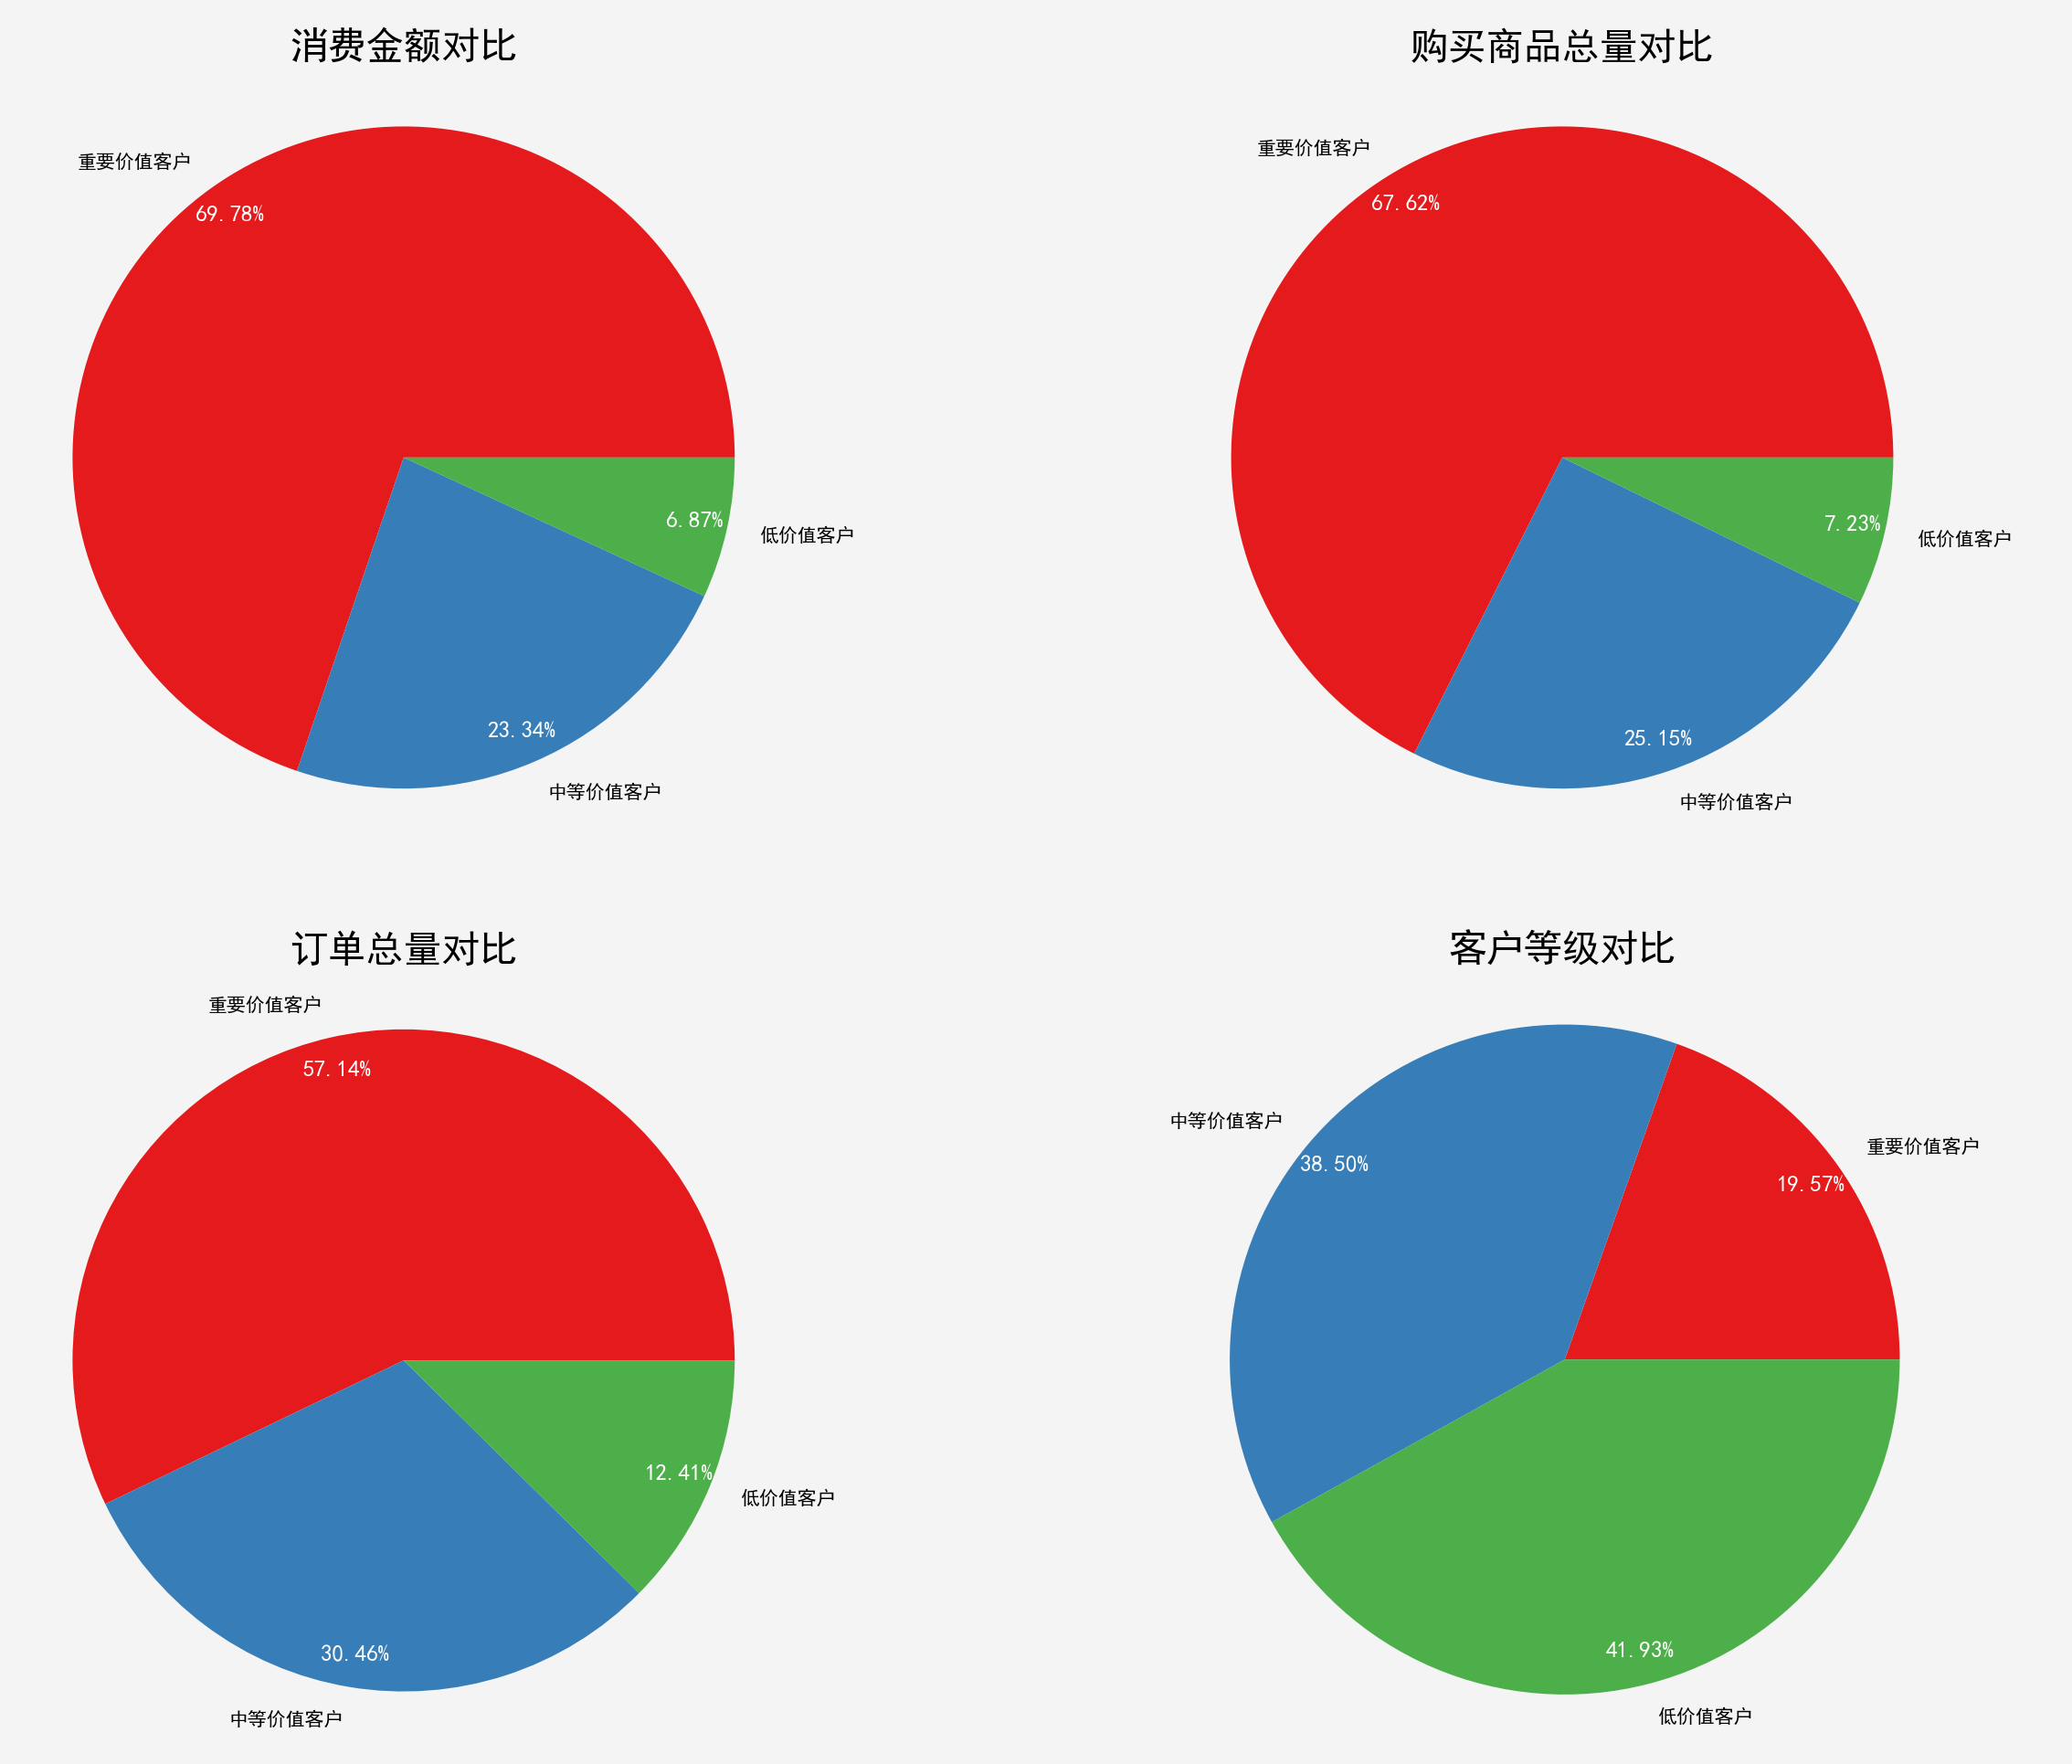

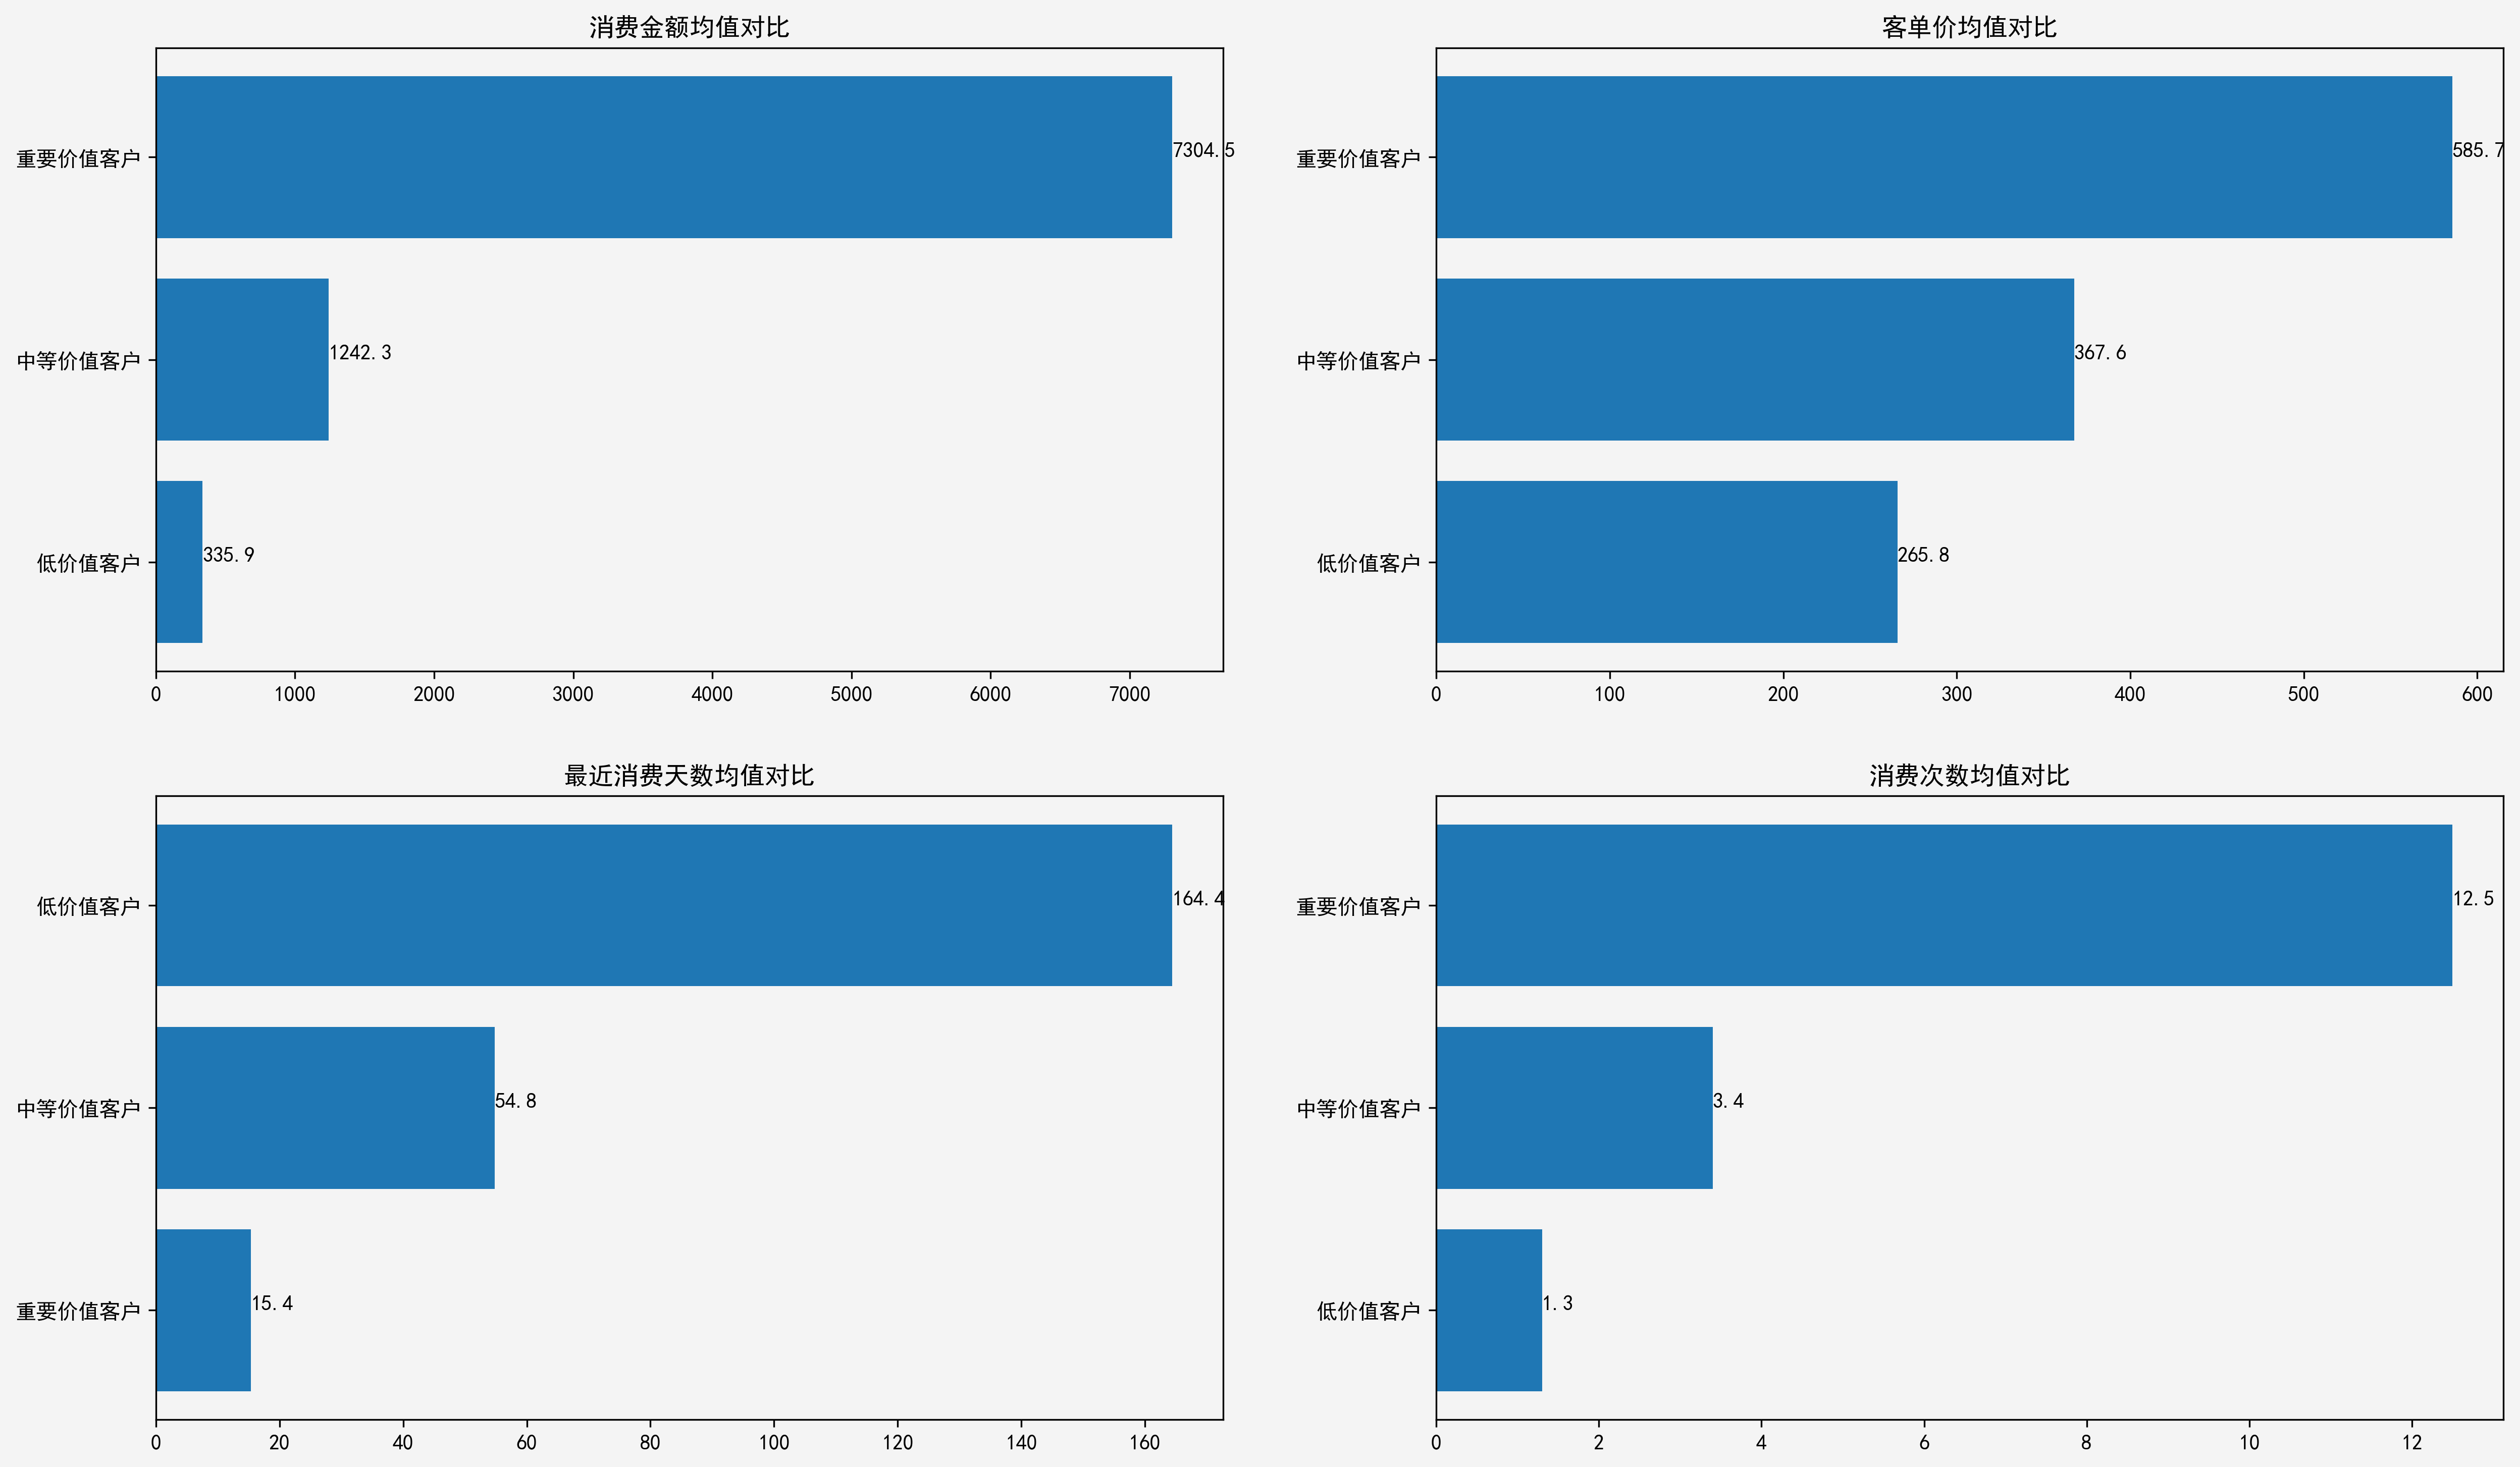

In [80]:
rfm_level.index = ['重要价值客户', '中等价值客户', '低价值客户']
customer_level_pie(rfm_level)
customer_level_barh(rfm_level)

# 总结

本次分析主要使用python语言对某份英国电子零售企业的交易数据进行数据挖掘，使用RFM模型和K-Means聚类算法对用户进行分层，寻找有价值的用户。

无论是进行传统的RFM模型搭建还是使用聚类算法，都能将用户进行分层，在进行传统的RFM模型搭建的时候，使用两种方法来对用户进行分层，两个方法得出的结果有所差距，需要结合具体的业务来衡量所搭建模型的好坏。使用K-Means聚类算法也能在一定程度上将用户分层。但这两大类方法都有使用场景，也都有局限性。

RFM模型得到的不同层级的客户，可以采取针对性措施进行营销，但销售场景受限

聚类算法可以较好的区分出各层用户，对于业务来说解释性还不够，数据更新前后的两次聚类结果会不同。